# Monthly Mean SLA
Monthly mean sea level anomalies.

In [1]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 

In [2]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
# get percent Nans in rsl_daily['sea_level']


In [3]:
rsl_daily

<xarray.Dataset> Size: 571kB
Dimensions:       (record_id: 11, time: 10957)
Coordinates:
  * record_id     (record_id) int16 22B 140 500 520 570 ... 610 5470 5480 5520
  * time          (time) datetime64[ns] 88kB 1993-01-01 ... 2022-12-31
    lat           (record_id) float32 44B ...
    lon           (record_id) float32 44B ...
    station_name  (record_id) <U17 748B ...
Data variables:
    sea_level     (record_id, time) float32 482kB ...

In [4]:
data_coverage = rsl_daily.sea_level.count(dim='time')/len(rsl_daily.time)

#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

rsl_subset

<xarray.Dataset> Size: 439kB
Dimensions:       (record_id: 8, time: 10957)
Coordinates:
  * record_id     (record_id) int16 16B 500 520 570 580 590 600 610 5520
  * time          (time) datetime64[ns] 88kB 1993-01-01 ... 2022-12-31
    lat           (record_id) float32 32B 28.22 16.75 21.31 ... 21.43 20.03
    lon           (record_id) float32 32B 182.6 190.5 202.1 ... 202.2 204.2
    station_name  (record_id) <U17 544B 'Midway' 'Johnston' ... 'Kawaihae'
Data variables:
    sea_level     (record_id, time) float32 351kB -0.05425 -0.022 ... -0.1367

In [5]:
# make an rsl monthly mean for plotting
rsl_monthly = rsl_subset.resample(time='1ME').mean().squeeze()

## Absolute Value: satellite (trend removed)

In [6]:
# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.25deg_1993_2023.nc')

In [7]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  

In [8]:
# remove long term trend from rsl using polynomial fit
trend_mag_cmems, trend_line_cmems, trend_rate_cmems = process_trend_with_nan(cmems.sla)

cmems_detrended = cmems.sla - trend_line_cmems

# make a cmems monthly mean for plotting
cmems_monthly = cmems_detrended.resample(time='1ME').mean().squeeze()

# get the mean for each month of the year
cmems_climatology = cmems_monthly.groupby('time.month').mean(dim='time')

cmems_mmsla = cmems_monthly.groupby('time.month') - cmems_climatology


In [9]:
# plot the monthly_anomalies*100 for centimeters
cmems_cm = cmems_mmsla * 100

# make a slice of data from 2023 only
cmems_cm = cmems_cm.sel(time=slice('2022-03', '2023-02'))

# Get the month from the time coordinate
months = cmems_cm.time.dt.strftime('%b %Y')

# Plot the data with modified titles
mma = cmems_cm.plot(transform=crs, col='time', col_wrap=3,
                        aspect=cmems_cm.sizes['longitude'] / cmems_cm.sizes['latitude'],
                        subplot_kws={'projection': crs})

# Add coastlines and land features to each subplot
for i,ax in enumerate(mma.axs.flat):
    ax.coastlines()
    #ax.add_feature(cfeature.LAND, color='black')
    ax.set_title(months[i].values)
    ax.set_extent([cmems_cm.longitude.min(), cmems_cm.longitude.max(),  cmems_cm.latitude.min(), cmems_cm.latitude.max()]) 

# change the colorbar label
mma.cbar.set_label('Monthly Mean Sea Level Anomaly (cm)')  




NameError: name 'crs' is not defined

## Relative Value: tide station (trend removed)
### area-wide map with stations
### station plots: time series  
These should have ONI/ENSO phase included on them

In [8]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  

In [9]:
# remove trend from rsl_monthly
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_monthly.sea_level)

rsl_monthly_detrended = rsl_monthly.sea_level - trend_line_rsl

# add detrended rsl_monthly to rsl_monthly
rsl_monthly['sea_level_detrended'] = rsl_monthly_detrended
rsl_monthly['sea_level_detrended'].attrs = {'long_name': 'sea level anomaly', 'units': 'm'}

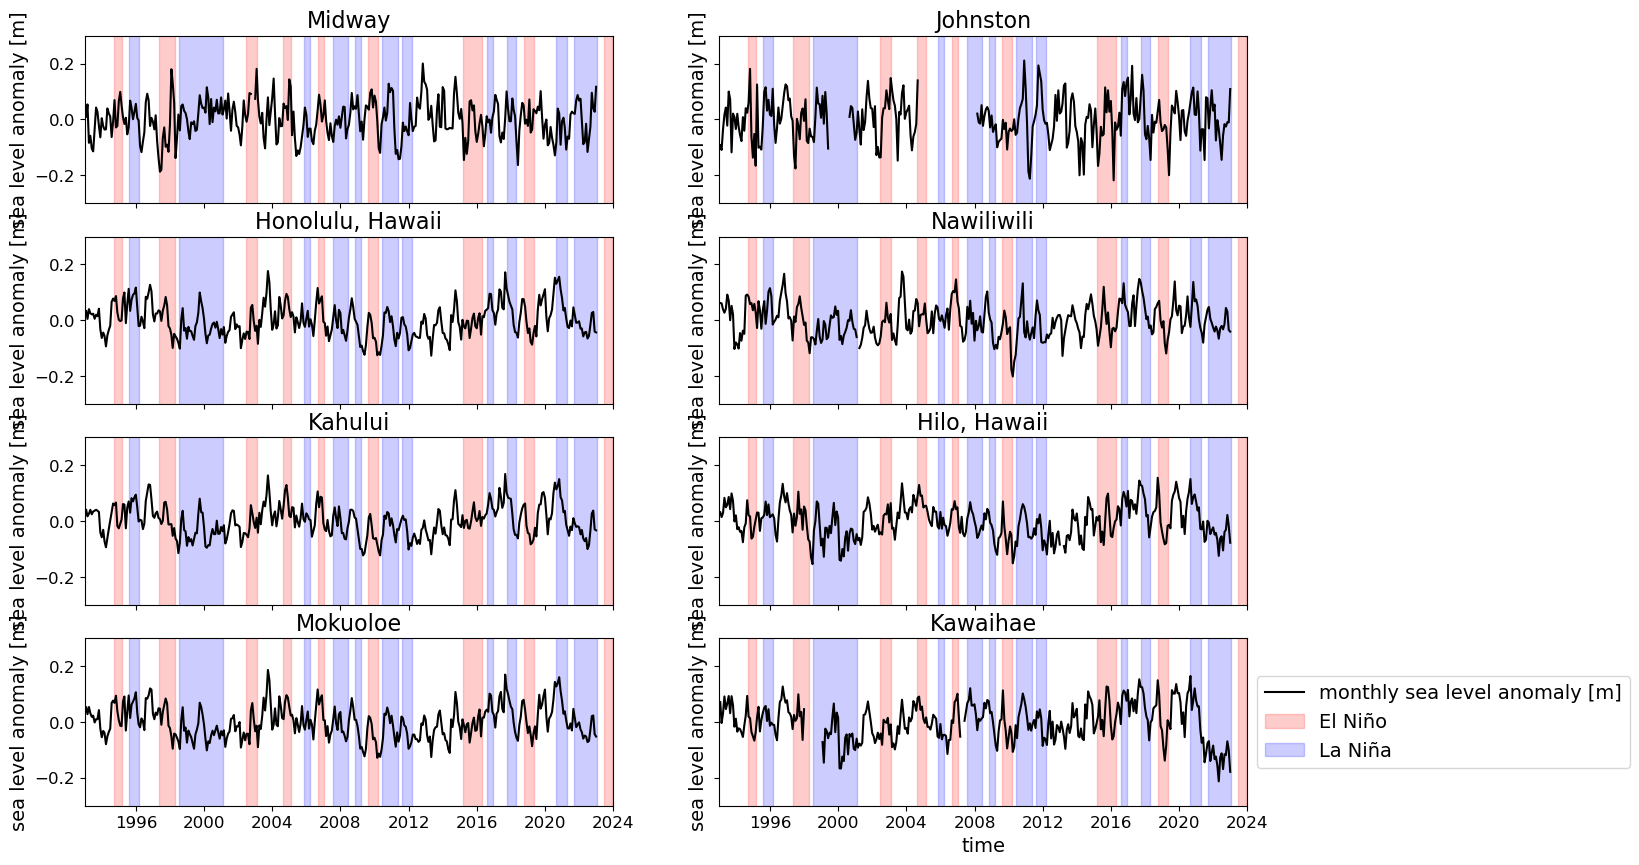

In [10]:

# get axis for the plots
fig,axes = plt.subplots(4,2,figsize=(15,10), sharex=True, sharey=True)
axes = axes.flatten()

# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'oni.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['Date'] )

record_ids = rsl_monthly['sea_level_detrended'].record_id.values

# iterate over each axis and plot the monthly mean
for i in range(len(record_ids)):
    ax = axes[i]
    rsl_monthly['sea_level_detrended'].isel(record_id=i).plot.line(ax=ax, x='time', label='monthly sea level anomaly [m]', color='black')

    # Shading El Niño events
    ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                    where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')

    # Shading La Niña events
    ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                    where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')
    
    ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
    ax.set_ylim([-0.3,0.3])

    ax.set_title(rsl_monthly['station_name'].values[i])

    if i < 7:
        ax.set_xlabel('')

#put legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Text(0.5, 1.0, 'Monthly Mean Sea Level Anomalies (1993-2023)')

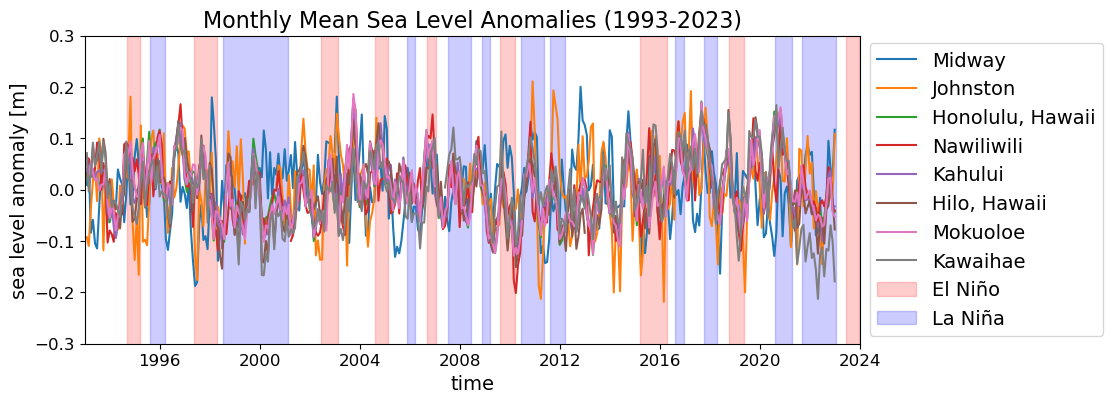

In [11]:
# make the same plot but only on one axis
fig,ax = plt.subplots()


rsl_monthly['sea_level_detrended'].plot.line(x='time', label=rsl_monthly['station_name'].values)

# add ONI shading
# Shading El Niño events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')

# Shading La Niña events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')

ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
ax.set_ylim([-0.3,0.3])

#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Monthly Mean Sea Level Anomalies (1993-2023)')
